In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator, FixedFormatter,
                               NullLocator)

In [11]:
dirt = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_up1zps/"

simu = [["nofric_min_phimin01_smo0"],
        ["nofric_min_phimin01_smo1"],
        ["nofric_min_phimin01_smo2"],
        ["nofric_min_phimin01_smo3"],
        ["nofric_min_phimin01_smo4"]]
refsimu = "../exp_up1/tup1_uup1_zps"

NI,NJ = np.shape(simu)
#NI=4

pdt = "/OVF_grid_T.nc"
pdu = "/OVF_grid_U.nc"

distrib = True
save = 1 
dpi = 400 
psave="gridtoce_up1_smo.png"

def bringbackto10(tempfield):
    """ Return the needed 10°C water for mixing at the actual temp
        bins galère avec des poids masqués
    """
    return( (1.-tempfield.mask)*(20.-tempfield.data)/10. )

In [12]:
fig = plt.figure(figsize = ((NI+2 if distrib else NI)*4, NJ*4), constrained_layout=False)
gs = GridSpec(NJ, NI+2 if distrib else NI, figure=fig)
palette = plt.get_cmap('RdBu_r',20)
hist_palette = plt.get_cmap('turbo',NI)
optptoce = {"cmap" : palette, "vmin" : 10, "vmax" : 20}
font = dict(fontsize=20)
# NI row, NJ simus pas row + 1 diagramme

# https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1
# as the bins are 1/5 withd, the sum does equals to 1 (stepfilled)
kwargs = dict(histtype='step', alpha=1., density=False, bins=np.linspace(10,20,21)) 
# not equivalent to put a nb of bins because based on Tmin and Tmax of the data, so may change
Tmin = 10. ; Tmax = 20.
il = 59 # 60km
nT = 101 # 102-1

# https://stackoverflow.com/questions/24738578/control-wspace-for-matplotlib-subplots
""" Reference
"""
pname = dirt+refsimu+pdt
dt = nc4.Dataset(pname)
reftheta = np.ma.masked_outside(dt.variables['thetao_inst'][:,:,1,:70], Tmin,Tmax) 
Vinitref = np.sum(1-reftheta.mask[0,:,:21]) # pas i=20 mais 21
nT,_,_ = np.shape(reftheta)
nt = nT ; tb=0 ; flag = True
while ( flag and tb<(nt-1) ):
    test = np.any(reftheta[tb,:,il]<20.)
    if test:
        flag=False
    else:
        tb+=1
reftoce   = reftheta[tb] # masked
refweight = bringbackto10(reftoce)/Vinitref
""" Smoothed penalised
"""
for j in range(NJ):
    toce_distrib = [(reftoce).flatten()] ; weight_distrib = [(refweight).flatten()]
    for i in range(NI):
        ax = fig.add_subplot(gs[j,i])
        #
        pname   = dirt+simu[i][j]+pdt
        pname_u = dirt+simu[i][j]+pdu
        """ if non existing
        """ 
        try:
            dt = nc4.Dataset(pname)
            du = nc4.Dataset(pname_u)
        except :
            toce_distrib.append([])
            weight_distrib.append([])
            ax.axis('off')
            print(j,i,simu[i][j],"non existing")
            continue
        theta = np.ma.masked_outside(dt.variables['thetao_inst'][:,:,1,:70], Tmin,Tmax) 
        Vinit = np.sum(1-reftheta.mask[0,:,:21])
        nt,_,_ = np.shape(theta)
        """ if aborted during the simulation
        """ 
        cfltxmax = np.nanmax(dt.variables['cfltu'][:,:,1,:70])
        cfltzmax = np.nanmax(dt.variables['cfltw'][:,:,1,:70])
        cfltmax  = cfltxmax + cfltzmax
        cfluxmax = np.nanmax(du.variables['cfluu'][:,:,1,:70])
        cfluzmax = np.nanmax(du.variables['cfluw'][:,:,1,:70])
        cflumax  = cfluxmax + cfluzmax
        if nt<nT or cfltmax>= 1. or cflumax>=1.:
            text = "%s%d) " % (chr(97+j),i) \
                 + "X"
            ax.axis('off')
            ax.text(0.5, 0.5, text,
                    va="center", ha="right",**font)
            ax.tick_params(labelbottom=False, labelleft=False)
            toce_distrib.append([])
            weight_distrib.append([])
            print(j,i,simu[i][j],"aborted"," cflt ",cfltmax," cflu ",cflumax)
            continue
        """ looking for the time of arrival
        """
        tb=0 ; flag = True
        while ( flag and tb<(nt-1) ):
            test = np.any(theta[tb,:,il]<20.)
            if test:
                flag=False
            else:
                tb+=1
        #
        toce = theta[tb]
        rpot = dt.variables['rpot'][0,:,1,:70]
        dt.close()
        # toce
        im = ax.imshow(toce, **optptoce) 
        ax.set_xticklabels([]) ; ax.set_yticklabels([])
        ax.set_xticks([])      ; ax.set_yticks([]) 
        ax.set_aspect(aspect='equal')
        ax.patch.set_color('0.8')
        text = "%s%d) " % (chr(97+j),i) \
             + "%2.1fh" % (tb/6) # 10min timeframe out of 1h
        ax.text(0., 0., text, va="center", ha="right",**font)            
        #
        #       volume * effective ratio of 10° water
        weight = rpot * bringbackto10(toce)/Vinit
        toce_distrib.append((toce).flatten())
        weight_distrib.append((weight).flatten())
        print(j,i,simu[i][j],"sum Vcold ",np.sum(weight))
    if distrib:
        # distrib
        ax_distrib = fig.add_subplot(gs[j,NI:])
        #gs0 = gs[j,NI:].subgridspec(4,1,hspace=0.) # split y
        #ax_distrib = fig.add_subplot(gs0[0])
        #ax_distrib = fig.add_subplot(gs0[1:3])
        #ax_distrib.hist(x=toce_distrib,weights=weight_distrib, **kwargs)
        ax_distrib.hist(x=toce_distrib[0],weights=weight_distrib[0],
                        color="grey",linewidth = 3.,**kwargs)
        for l in range(1,NI+1):
            ax_distrib.hist(x=toce_distrib[l],weights=weight_distrib[l],
                            color=hist_palette(l),linewidth = 2.,**kwargs)
        ax_distrib.set_xlim((Tmin,Tmax))
        ax_distrib.set_ylim(0,0.4)
        ax_distrib.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        ax_distrib.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        ax_distrib.xaxis.set_minor_locator(AutoMinorLocator())
        ax_distrib.yaxis.set_minor_locator(AutoMinorLocator())
        ax_distrib.tick_params(axis = "y", which = 'both', width=1.5, labelsize = 20, pad = 5)
        ax_distrib.tick_params(axis = 'x', which = 'both', width=1.5, labelsize = 20, pad = 10)
        ax_distrib.tick_params(which='minor',length = 4)
        ax_distrib.tick_params(which='major',length = 6)
gs.update(wspace=0)
#fig.suptitle("GridSpec")
#format_axes(fig)

#plt.show()
print("saving : %s" % psave)
fig.savefig(psave, dpi = dpi, orientation='landscape')
plt.close()

0 0 nofric_min_phimin01_smo0 aborted  cflt  0.34978113  cflu  4.4434576
0 1 nofric_min_phimin01_smo1 aborted  cflt  0.37026107  cflu  1.7726071
0 2 nofric_min_phimin01_smo2 sum Vcold  0.9973783887864118
0 3 nofric_min_phimin01_smo3 sum Vcold  0.9978326025417102
0 4 nofric_min_phimin01_smo4 sum Vcold  0.9982858836299097
saving : gridtoce_up1_smo.png


In [16]:
dirt = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_up1zps/"

simu = [["min_phimin01_smo0"],
        ["min_phimin01_smo1"],
        ["min_phimin01_smo2"],
        ["min_phimin01_smo3"],
        ["min_phimin01_smo4"]]
refsimu = "../exp_up1/tup1_uup1_zps"

NI,NJ = np.shape(simu)
#NI=4

pdt = "/OVF_grid_T.nc"
pdu = "/OVF_grid_U.nc"

distrib = True
save = 1 
dpi = 400 
psave="gridtoce_up1_smo_fric.png"

def bringbackto10(tempfield):
    """ Return the needed 10°C water for mixing at the actual temp
        bins galère avec des poids masqués
    """
    return( (1.-tempfield.mask)*(20.-tempfield.data)/10. )

In [17]:
fig = plt.figure(figsize = ((NI+2 if distrib else NI)*4, NJ*4), constrained_layout=False)
gs = GridSpec(NJ, NI+2 if distrib else NI, figure=fig)
palette = plt.get_cmap('RdBu_r',20)
hist_palette = plt.get_cmap('turbo',NI)
optptoce = {"cmap" : palette, "vmin" : 10, "vmax" : 20}
font = dict(fontsize=20)
# NI row, NJ simus pas row + 1 diagramme

# https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1
# as the bins are 1/5 withd, the sum does equals to 1 (stepfilled)
kwargs = dict(histtype='step', alpha=1., density=False, bins=np.linspace(10,20,21)) 
# not equivalent to put a nb of bins because based on Tmin and Tmax of the data, so may change
Tmin = 10. ; Tmax = 20.
il = 59 # 60km
nT = 101 # 102-1

# https://stackoverflow.com/questions/24738578/control-wspace-for-matplotlib-subplots
""" Reference
"""
pname = dirt+refsimu+pdt
dt = nc4.Dataset(pname)
reftheta = np.ma.masked_outside(dt.variables['thetao_inst'][:,:,1,:70], Tmin,Tmax) 
Vinitref = np.sum(1-reftheta.mask[0,:,:21]) # pas i=20 mais 21
nT,_,_ = np.shape(reftheta)
nt = nT ; tb=0 ; flag = True
while ( flag and tb<(nt-1) ):
    test = np.any(reftheta[tb,:,il]<20.)
    if test:
        flag=False
    else:
        tb+=1
reftoce   = reftheta[tb] # masked
refweight = bringbackto10(reftoce)/Vinitref
""" Smoothed penalised
"""
for j in range(NJ):
    toce_distrib = [(reftoce).flatten()] ; weight_distrib = [(refweight).flatten()]
    for i in range(NI):
        ax = fig.add_subplot(gs[j,i])
        #
        pname   = dirt+simu[i][j]+pdt
        pname_u = dirt+simu[i][j]+pdu
        """ if non existing
        """ 
        try:
            dt = nc4.Dataset(pname)
            du = nc4.Dataset(pname_u)
        except :
            toce_distrib.append([])
            weight_distrib.append([])
            ax.axis('off')
            print(j,i,simu[i][j],"non existing")
            continue
        theta = np.ma.masked_outside(dt.variables['thetao_inst'][:,:,1,:70], Tmin,Tmax) 
        Vinit = np.sum(1-reftheta.mask[0,:,:21])
        nt,_,_ = np.shape(theta)
        """ if aborted during the simulation
        """ 
        cfltxmax = np.nanmax(dt.variables['cfltu'][:,:,1,:70])
        cfltzmax = np.nanmax(dt.variables['cfltw'][:,:,1,:70])
        cfltmax  = cfltxmax + cfltzmax
        cfluxmax = np.nanmax(du.variables['cfluu'][:,:,1,:70])
        cfluzmax = np.nanmax(du.variables['cfluw'][:,:,1,:70])
        cflumax  = cfluxmax + cfluzmax
        if nt<nT :
            text = "%s%d) " % (chr(97+j),i) \
                 + "X"
            ax.axis('off')
            ax.text(0.5, 0.5, text,
                    va="center", ha="right",**font)
            ax.tick_params(labelbottom=False, labelleft=False)
            toce_distrib.append([])
            weight_distrib.append([])
            print(j,i,simu[i][j],"aborted"," cflt ",cfltmax," cflu ",cflumax)
            continue
        """ looking for the time of arrival
        """
        tb=0 ; flag = True
        while ( flag and tb<(nt-1) ):
            test = np.any(theta[tb,:,il]<20.)
            if test:
                flag=False
            else:
                tb+=1
        #
        toce = theta[tb]
        rpot = dt.variables['rpot'][0,:,1,:70]
        dt.close()
        # toce
        im = ax.imshow(toce, **optptoce) 
        ax.set_xticklabels([]) ; ax.set_yticklabels([])
        ax.set_xticks([])      ; ax.set_yticks([]) 
        ax.set_aspect(aspect='equal')
        ax.patch.set_color('0.8')
        text = "%s%d) " % (chr(97+j),i) \
             + "%2.1fh" % (tb/6) # 10min timeframe out of 1h
        ax.text(0., 0., text, va="center", ha="right",**font)            
        #
        #       volume * effective ratio of 10° water
        weight = rpot * bringbackto10(toce)/Vinit
        toce_distrib.append((toce).flatten())
        weight_distrib.append((weight).flatten())
        print(j,i,simu[i][j],"sum Vcold ",np.sum(weight))
    if distrib:
        # distrib
        ax_distrib = fig.add_subplot(gs[j,NI:])
        #gs0 = gs[j,NI:].subgridspec(4,1,hspace=0.) # split y
        #ax_distrib = fig.add_subplot(gs0[0])
        #ax_distrib = fig.add_subplot(gs0[1:3])
        #ax_distrib.hist(x=toce_distrib,weights=weight_distrib, **kwargs)
        ax_distrib.hist(x=toce_distrib[0],weights=weight_distrib[0],
                        color="grey",linewidth = 3.,**kwargs)
        for l in range(1,NI+1):
            ax_distrib.hist(x=toce_distrib[l],weights=weight_distrib[l],
                            color=hist_palette(l),linewidth = 2.,**kwargs)
        ax_distrib.set_xlim((Tmin,Tmax))
        ax_distrib.set_ylim(0,0.4)
        ax_distrib.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        ax_distrib.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        ax_distrib.xaxis.set_minor_locator(AutoMinorLocator())
        ax_distrib.yaxis.set_minor_locator(AutoMinorLocator())
        ax_distrib.tick_params(axis = "y", which = 'both', width=1.5, labelsize = 20, pad = 5)
        ax_distrib.tick_params(axis = 'x', which = 'both', width=1.5, labelsize = 20, pad = 10)
        ax_distrib.tick_params(which='minor',length = 4)
        ax_distrib.tick_params(which='major',length = 6)
gs.update(wspace=0)
#fig.suptitle("GridSpec")
#format_axes(fig)

#plt.show()
print("saving : %s" % psave)
fig.savefig(psave, dpi = dpi, orientation='landscape')
plt.close()

0 0 min_phimin01_smo0 sum Vcold  0.9964738710343877
0 1 min_phimin01_smo1 sum Vcold  0.9969243687706489
0 2 min_phimin01_smo2 sum Vcold  0.9973783887864118
0 3 min_phimin01_smo3 sum Vcold  0.9978326025417102
0 4 min_phimin01_smo4 sum Vcold  0.9982858836299097
saving : gridtoce_up1_smo_fric.png


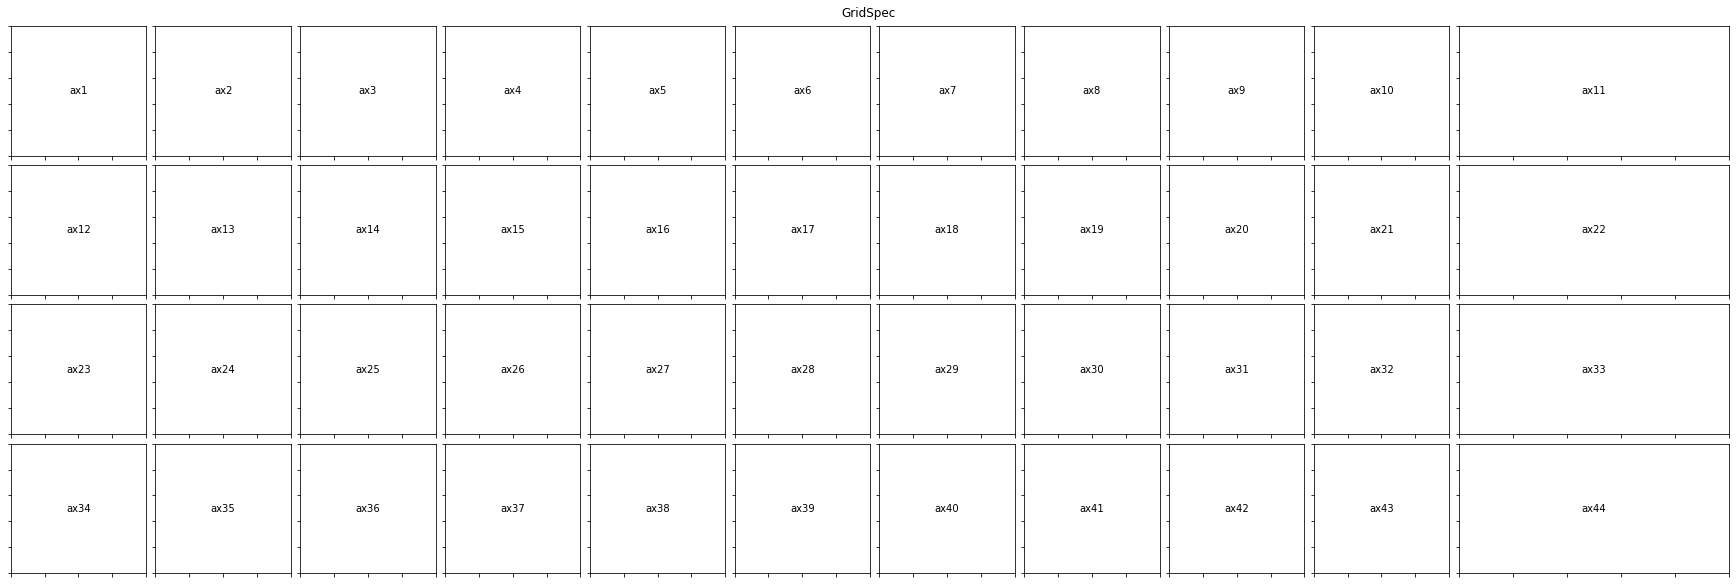

In [5]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize = ((NI+2 if distrib else NI)*2, NJ*2), constrained_layout=True) # len of rows then len of columns
gs = GridSpec(NJ, NI+2, figure=fig) # j rows, i columns
for j in range(NJ):
    for i in range(NI):
        fig.add_subplot(gs[j,i])
    fig.add_subplot(gs[j,NI:])
#fig.add_subplot(gs[0,  NI:])
#fig.add_subplot(gs[1, :NI])
#fig.add_subplot(gs[1:, -1])
#fig.add_subplot(gs[-1, 0])
#fig.add_subplot(gs[-1, 1])
#fig.add_subplot(gs[-1, -2])

fig.suptitle("GridSpec")
format_axes(fig)

plt.show()

---
---
---
## Avancé du front - réference

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator, FixedFormatter,
                               NullLocator)

In [11]:
dirt = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_up1/"

refsimu = "tup1_uup1_zco" ; psave="timeline_zco.png"

NI,NJ = (4,1)

#NI=5

pdt = "/OVF_grid_T.nc"
pdu = "/OVF_grid_U.nc"

distrib = True
save = 1 
dpi = 200 

def bringbackto10(tempfield):
    """ Return the needed 10°C water for mixing at the actual temp
        bins galère avec des poids masqués
    """
    return( (1.-tempfield.mask)*(20.-tempfield.data)/10. )

In [12]:
fig = plt.figure(figsize = ((NI+2 if distrib else NI)*4, NJ*4), constrained_layout=True)
gs = GridSpec(NJ, (NI+2 if distrib else NI), figure=fig)
palette = plt.get_cmap('RdBu_r',20)
hist_palette = plt.get_cmap('turbo',NI)
optptoce = {"cmap" : palette, "vmin" : 10, "vmax" : 20}
font = dict(fontsize=20)

# NI row, NJ simus pas row + 1 diagramme

# https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1
# as the bins are 1/5 withd, the sum does equals to 1 (stepfilled)
kwargs = dict(histtype='step', alpha=1., density=False, bins=np.linspace(10,20,21)) 
# not equivalent to put a nb of bins because based on Tmin and Tmax of the data, so may change
Tmin = 10. ; Tmax = 20.
xfront=[21,45,59,90]
#il = 59 # 60km
nT = 101 # 102-1

""" Reference
"""
pname = dirt+refsimu+pdt
dt = nc4.Dataset(pname)
reftheta = np.ma.masked_outside(dt.variables['thetao_inst'][:,:,1,:100], Tmin,Tmax) 
Vinitref = np.sum(1-reftheta.mask[0,:,:21]) # pas i=20 mais 21
nt,_,_ = np.shape(reftheta)

""" Smoothed penalised
"""
for j in range(NJ):
    toce_distrib = [] ; weight_distrib = []
    for i in range(NI):
        ax = fig.add_subplot(gs[j,i])
        il = xfront[i]
        """ looking for the time of arrival
        """
        tb=0 ; flag = True
        while ( flag and tb<(nt-1) ):
            test = np.any(reftheta[tb,:,il]<20.)
            if test:
                flag=False
            else:
                tb+=1
        toce = reftheta[tb]    
        #dt.close()
        """ plot front
        """
        im = ax.imshow(toce, **optptoce) 
        ax.set_xticklabels([]) ; ax.set_yticklabels([])
        ax.set_xticks([])      ; ax.set_yticks([]) 
        #ax.set_aspect(aspect='equal')
        ax.patch.set_color('0.8')
        text = "%s) " % (chr(97+i)) \
             + "%2.1fh" % (tb/6) # 10min timeframe out of 1h
        ax.text(0., 0., text, va="center", ha="right",**font)            
        #
        #       volume * effective ratio of 10° water
        #
        weight = bringbackto10(toce)/Vinitref
        toce_distrib.append((toce).flatten())
        weight_distrib.append((weight).flatten())
        print(j,i,"sum Vcold ",np.sum(weight))
        #
    if distrib:
        # distrib
        ax_distrib = fig.add_subplot(gs[j,NI:])
        #ax_distrib.hist(x=toce_distrib,weights=weight_distrib, **kwargs)
        ax_distrib.hist(x=toce_distrib[0],weights=weight_distrib[0],
                        color="grey",linewidth = 4.,**kwargs)
        for l in range(len(xfront)):
            ax_distrib.hist(x=toce_distrib[l],weights=weight_distrib[l],
                            color=hist_palette(l),linewidth = 3.,**kwargs)
        ax_distrib.set_xlim((Tmin,Tmax))
        ax_distrib.set_ylim(0,0.5)
        ax_distrib.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        ax_distrib.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        ax_distrib.xaxis.set_minor_locator(AutoMinorLocator())
        ax_distrib.yaxis.set_minor_locator(AutoMinorLocator())
        ax_distrib.tick_params(axis = "y", which = 'both', width=1.5, labelsize = 20, pad = 5)
        ax_distrib.tick_params(axis = 'x', which = 'both', width=1.5, labelsize = 20, pad = 10)
        ax_distrib.tick_params(which='minor',length = 4)
        ax_distrib.tick_params(which='major',length = 6)
#fig.suptitle("GridSpec")
#format_axes(fig)

#plt.show()
print("saving : %s" % psave)
fig.savefig(psave, dpi = dpi)
plt.close()

0 0 sum Vcold  1.0010388011932374
0 1 sum Vcold  1.000780625152588
0 2 sum Vcold  1.000780156135559
0 3 sum Vcold  1.000780219078064
saving : timeline_zco.png


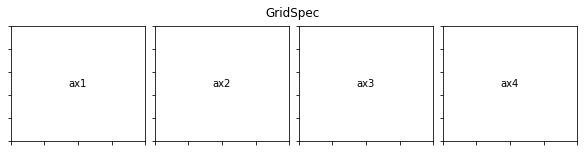

In [6]:
distrib = False
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize = ((NI+2 if distrib else NI)*2, NJ*2), constrained_layout=True) # len of rows then len of columns
gs = GridSpec(NJ, (NI+2 if distrib else NI), figure=fig) # j rows, i columns
for j in range(NJ):
    for i in range(NI):
        fig.add_subplot(gs[j,i])
    if distrib : fig.add_subplot(gs[j,NI:])
#fig.add_subplot(gs[0,  NI:])
#fig.add_subplot(gs[1, :NI])
#fig.add_subplot(gs[1:, -1])
#fig.add_subplot(gs[-1, 0])
#fig.add_subplot(gs[-1, 1])
#fig.add_subplot(gs[-1, -2])

fig.suptitle("GridSpec")
format_axes(fig)

plt.show()

---
---
---

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator, FixedFormatter,
                               NullLocator)

In [11]:
dirt = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_up1zps/"

simu = [["min_phimin01_smo0","min_phimin0001_smo0"],
        ["min_phimin01_smo1","min_phimin0001_smo1"],
        ["min_phimin01_smo2","min_phimin0001_smo2"],
        ["min_phimin01_smo3","min_phimin0001_smo3"],
        ["min_phimin01_smo4","min_phimin0001_smo4"]]
psave="gridtoce_up1_zps_smo.png"

#simu = [["nofric_min_phimin01_smo0","nofric_min_phimin0001_smo0"],
#        ["nofric_min_phimin01_smo1","nofric_min_phimin0001_smo1"],
#        ["nofric_min_phimin01_smo2","nofric_min_phimin0001_smo2"],
#        ["nofric_min_phimin01_smo3","nofric_min_phimin0001_smo3"],
#        ["nofric_min_phimin01_smo4","nofric_min_phimin0001_smo4"]]
#psave="gridtoce_up1_zps_nofricsmo.png"

refsimu = "../exp_up1/tup1_uup1_zps"

NI,NJ = np.shape(simu)
#NI=4

pdt = "/OVF_grid_T.nc"
pdu = "/OVF_grid_U.nc"

distrib = True
save = 1 
dpi = 400 


def bringbackto10(tempfield):
    """ Return the needed 10°C water for mixing at the actual temp
        bins galère avec des poids masqués
    """
    return( (1.-tempfield.mask)*(20.-tempfield.data)/10. )

In [12]:
fig = plt.figure(figsize = ((NI+2 if distrib else NI)*4, NJ*4), constrained_layout=False)
gs = GridSpec(NJ, NI+2 if distrib else NI, figure=fig)
palette = plt.get_cmap('RdBu_r',20)
hist_palette = plt.get_cmap('turbo',NI)
optptoce = {"cmap" : palette, "vmin" : 10, "vmax" : 20}
font = dict(fontsize=20)
# NI row, NJ simus pas row + 1 diagramme

# https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1
# as the bins are 1/5 withd, the sum does equals to 1 (stepfilled)
kwargs = dict(histtype='step', alpha=1., density=False, bins=np.linspace(10,20,21)) 
# not equivalent to put a nb of bins because based on Tmin and Tmax of the data, so may change
Tmin = 10. ; Tmax = 20.
il = 59 # 60km
nT = 101 # 102-1

# https://stackoverflow.com/questions/24738578/control-wspace-for-matplotlib-subplots
""" Reference
"""
pname = dirt+refsimu+pdt
dt = nc4.Dataset(pname)
reftheta = np.ma.masked_outside(dt.variables['thetao_inst'][:,:,1,:70], Tmin,Tmax) 
Vinitref = np.sum(1-reftheta.mask[0,:,:21]) # pas i=20 mais 21
nT,_,_ = np.shape(reftheta)
nt = nT ; tb=0 ; flag = True
while ( flag and tb<(nt-1) ):
    test = np.any(reftheta[tb,:,il]<20.)
    if test:
        flag=False
    else:
        tb+=1
reftoce   = reftheta[tb] # masked
refweight = bringbackto10(reftoce)/Vinitref
""" Smoothed penalised
"""
for j in range(NJ):
    toce_distrib = [(reftoce).flatten()] ; weight_distrib = [(refweight).flatten()]
    for i in range(NI):
        ax = fig.add_subplot(gs[j,i])
        #
        pname   = dirt+simu[i][j]+pdt
        pname_u = dirt+simu[i][j]+pdu
        """ if non existing
        """ 
        try:
            dt = nc4.Dataset(pname)
            du = nc4.Dataset(pname_u)
        except :
            toce_distrib.append([])
            weight_distrib.append([])
            ax.axis('off')
            print(j,i,simu[i][j],"non existing")
            continue
        theta = np.ma.masked_outside(dt.variables['thetao_inst'][:,:,1,:70], Tmin,Tmax) 
        Vinit = np.sum(1-reftheta.mask[0,:,:21])
        nt,_,_ = np.shape(theta)
        """ if aborted during the simulation
        """ 
        cfltxmax = np.nanmax(dt.variables['cfltu'][:,:,1,:70])
        cfltzmax = np.nanmax(dt.variables['cfltw'][:,:,1,:70])
        cfltmax  = cfltxmax + cfltzmax
        cfluxmax = np.nanmax(du.variables['cfluu'][:,:,1,:70])
        cfluzmax = np.nanmax(du.variables['cfluw'][:,:,1,:70])
        cflumax  = cfluxmax + cfluzmax
        if nt<nT or cfltmax>= 1. or cflumax>=1.:
            text = "%s%d) " % (chr(97+j),i) \
                 +        r"$\alpha     $=%.2f" % (cfltmax)  \
                 + "\n" + r"$\alpha_x   $=%.2f" % (cfltxmax) \
                 + "\n" + r"$\alpha_z   $=%.2f" % (cfltzmax) \
                 + "\n"                                       \
                 + "\n" + r"$\alpha_u   $=%.2f" % (cflumax)  \
                 + "\n" + r"$\alpha_{ux}$=%.2f" % (cfluxmax) \
                 + "\n" + r"$\alpha_{uz}$=%.2f" % (cfluzmax) 
            ax.axis('off')
            ax.text(0.5, 0.5, text,
                    va="center", ha="right",**font)
            ax.tick_params(labelbottom=False, labelleft=False)
            toce_distrib.append([])
            weight_distrib.append([])
            print(j,i,simu[i][j],"aborted"," cflt ",cfltmax," cflu ",cflumax)
            continue
        """ looking for the time of arrival
        """
        tb=0 ; flag = True
        while ( flag and tb<(nt-1) ):
            test = np.any(theta[tb,:,il]<20.)
            if test:
                flag=False
            else:
                tb+=1
        #
        toce = theta[tb]
        rpot = dt.variables['rpot'][0,:,1,:70]
        dt.close()
        # toce
        im = ax.imshow(toce, **optptoce) 
        ax.set_xticklabels([]) ; ax.set_yticklabels([])
        ax.set_xticks([])      ; ax.set_yticks([]) 
        ax.set_aspect(aspect='equal')
        ax.patch.set_color('0.8')
        text = "%s%d) " % (chr(97+j),i) \
             + "%2.1fh" % (tb/6) # 10min timeframe out of 1h
        ax.text(0., 0., text, va="center", ha="right",**font)            
        #
        #       volume * effective ratio of 10° water
        weight = rpot * bringbackto10(toce)/Vinit
        toce_distrib.append((toce).flatten())
        weight_distrib.append((weight).flatten())
        print(j,i,simu[i][j],"sum Vcold ",np.sum(weight))
    if distrib:
        # distrib
        ax_distrib = fig.add_subplot(gs[j,NI:])
        #gs0 = gs[j,NI:].subgridspec(4,1,hspace=0.) # split y
        #ax_distrib = fig.add_subplot(gs0[0])
        #ax_distrib = fig.add_subplot(gs0[1:3])
        #ax_distrib.hist(x=toce_distrib,weights=weight_distrib, **kwargs)
        ax_distrib.hist(x=toce_distrib[0],weights=weight_distrib[0],
                        color="grey",linewidth = 3.,**kwargs)
        for l in range(1,NI+1):
            ax_distrib.hist(x=toce_distrib[l],weights=weight_distrib[l],
                            color=hist_palette(l),linewidth = 2.,**kwargs)
        ax_distrib.set_xlim((Tmin,Tmax))
        ax_distrib.set_ylim(0,0.4)
        ax_distrib.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        ax_distrib.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        ax_distrib.xaxis.set_minor_locator(AutoMinorLocator())
        ax_distrib.yaxis.set_minor_locator(AutoMinorLocator())
        ax_distrib.tick_params(axis = "y", which = 'both', width=1.5, labelsize = 20, pad = 5)
        ax_distrib.tick_params(axis = 'x', which = 'both', width=1.5, labelsize = 20, pad = 10)
        ax_distrib.tick_params(which='minor',length = 4)
        ax_distrib.tick_params(which='major',length = 6)
gs.update(wspace=0)
#fig.suptitle("GridSpec")
#format_axes(fig)

#plt.show()
print("saving : %s" % psave)
fig.savefig(psave, dpi = dpi, orientation='landscape')
plt.close()

0 0 nofric_min_phimin01_smo0 aborted  cflt  0.34978113  cflu  4.4434576
0 1 nofric_min_phimin01_smo1 aborted  cflt  0.37026206  cflu  1.7726095
0 2 nofric_min_phimin01_smo2 sum Vcold  0.9850730875302965
0 3 nofric_min_phimin01_smo3 sum Vcold  0.9855272687593793
0 4 nofric_min_phimin01_smo4 sum Vcold  0.9859805335380789
1 0 nofric_min_phimin0001_smo0 aborted  cflt  0.27031565  cflu  5.195306
1 1 nofric_min_phimin0001_smo1 aborted  cflt  0.27586865  cflu  4.740096
1 2 nofric_min_phimin0001_smo2 aborted  cflt  0.30752096  cflu  3.5425882
1 3 nofric_min_phimin0001_smo3 aborted  cflt  4.058309  cflu  4.3381815
1 4 nofric_min_phimin0001_smo4 aborted  cflt  0.39946276  cflu  2.2564387
saving : gridtoce_up1_zps_nofricsmo.png
